# CountVectorizedTags with GradientBoostingClassifier

The tags generated in the lexicon tagging stage were count vectorised in the feature generation notebook. 

To this set of features we apply a gradientboostingclassifier.

## Import Libraries

In [1]:
# set sys path to access scripts
import sys
sys.path.append('../')

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

# custom scripts
import scripts.evaluator as evaluator
import scripts.config as config
from scripts.helpers import get_regex
from scripts.helpers import split_sentence
from scripts.helpers import list_to_comma_sep_string
from scripts.helpers import list_to_string
from scripts.helpers import pos_tagging

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Import Data

In [2]:
df_phrase = pd.read_csv(config.FINANCIAL_PHRASE_BANK)
df_domain_dict = pd.read_csv(config.DOMAIN_DICTIONARY)

df_phrase['tags'] = df_phrase['tags'].replace(np.NaN,'')

## Create Train/Test Sets, Define Model, Train, Test

experiment            result  accuarcy  precision  recall  fscore  \
0  cvt & gbc  cross validation     0.775      0.762   0.708   0.728   
1  cvt & gbc              test     0.775      0.764   0.718   0.737   

                                   misclass_indicies  \
0                                                 []   
1  [5, 8, 18, 19, 20, 23, 31, 33, 36, 40, 46, 63,...   

                                         predictions  
0                                                 []  
1  [positive, neutral, neutral, neutral, neutral,...

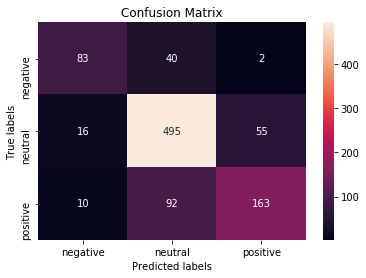

In [3]:
# get countvectors from data frame
column_names = [column_name for column_name in list(df_phrase.columns) if column_name[0:6]=='count_']

# test train split
X_train, X_test, y_train, y_test = train_test_split(df_phrase[column_names], 
                                                    df_phrase['sentiment'], 
                                                    test_size=config.TEST_SIZE, 
                                                    random_state=config.RANDOM_STATE)

# reset indicies -- required for heirachical classifier
# comparisson of models misclassified indicies in seperate notebook
# indicies required to be in line accross notebooks
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# model
model = Pipeline([('model', GradientBoostingClassifier())])

# evaluator fits, predicts and returns metrics for model
_eval = evaluator.evaluator('cvt & gbc', model, X_train, y_train, X_test, y_test)
_eval.plot_confusion()
_eval.get_results()

In [4]:
_eval.save_results('results/results.csv')

## Model Parameters

A guide to hyperparmeter tuning for gradient boosting machines:
Resource: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

max_depth = 4
min_samples_leaf = 3
max_leaf_nodes = 5
max_features = None (detault)
min_samples_split = 5
min_weight_fraction_leaf = 0.0 (default)

### Max Depth

In [117]:
param='max_depth'
for i, param_val in enumerate([2,3,4,5]):
    if i ==0:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(max_depth=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results_all = _eval.get_results()
        results_all['param_val'] = param_val
    else:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(max_depth=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results = _eval.get_results()
        results['param_val'] = param_val    
        results_all = results_all.append(results, sort=False)

In [118]:
results_all = results_all[results_all.result=='cross validation']
results_all.reset_index(inplace=True, drop=True)

results_formatted = {'experiment':[],'param':[],'param_val':[],'metric':[],'value':[]}
for i in list(results_all.index):
    results = results_all.iloc[i]
    for metric in ['accuarcy', 'precision', 'recall']:
        results_formatted['experiment'].append(results.experiment)
        results_formatted['param'].append(param)
        results_formatted['param_val'].append(results.param_val)
        results_formatted['metric'].append(metric)
        results_formatted['value'].append(results[metric])

results_formatted = pd.DataFrame(results_formatted)
results_formatted_all = pd.DataFrame(results_formatted)

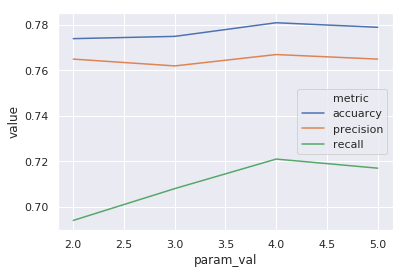

In [119]:
sns.set()
sns.lineplot(x=results_formatted.param_val, y=results_formatted.value, hue=results_formatted.metric)

### min_samples_leaf

In [120]:
param='min_samples_leaf'
for i, param_val in enumerate([1,2,3,4,5]):
    if i ==0:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(min_samples_leaf=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results_all = _eval.get_results()
        results_all['param_val'] = param_val
    else:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(min_samples_leaf=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results = _eval.get_results()
        results['param_val'] = param_val    
        results_all = results_all.append(results, sort=False)

In [121]:
results_all = results_all[results_all.result=='cross validation']
results_all.reset_index(inplace=True, drop=True)

results_formatted = {'experiment':[],'param':[],'param_val':[],'metric':[],'value':[]}
for i in list(results_all.index):
    results = results_all.iloc[i]
    for metric in ['accuarcy', 'precision', 'recall']:
        results_formatted['experiment'].append(results.experiment)
        results_formatted['param'].append(param)
        results_formatted['param_val'].append(results.param_val)
        results_formatted['metric'].append(metric)
        results_formatted['value'].append(results[metric])
results_formatted = pd.DataFrame(results_formatted)
results_formatted_all=results_formatted_all.append(results_formatted)

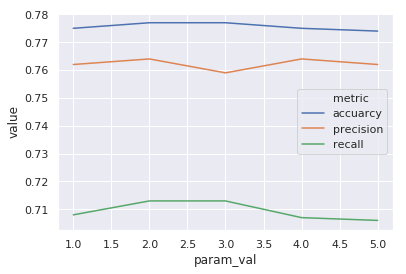

In [122]:
sns.set()
sns.lineplot(x=results_formatted.param_val, y=results_formatted.value, hue=results_formatted.metric)

In [123]:
results_formatted_all[0:2]

experiment      param  param_val     metric  value
0         ar  max_depth          2   accuarcy  0.774
1         ar  max_depth          2  precision  0.765

### max_leaf_nodes

In [124]:
param='max_leaf_nodes'
for i, param_val in enumerate([None,2,3,4,5,6]):
    if i ==0:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(max_leaf_nodes=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results_all = _eval.get_results()
        results_all['param_val'] = param_val
    else:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(max_leaf_nodes=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results = _eval.get_results()
        results['param_val'] = param_val    
        results_all = results_all.append(results, sort=False)

In [125]:
results_all = results_all[results_all.result=='cross validation']
results_all.reset_index(inplace=True, drop=True)
results_all.param_val.fillna(0, inplace=True)

results_formatted = {'experiment':[],'param':[],'param_val':[],'metric':[],'value':[]}
for i in list(results_all.index):
    results = results_all.iloc[i]
    for metric in ['accuarcy', 'precision', 'recall']:
        results_formatted['experiment'].append(results.experiment)
        results_formatted['param'].append(param)
        results_formatted['param_val'].append(results.param_val)
        results_formatted['metric'].append(metric)
        results_formatted['value'].append(results[metric])
results_formatted = pd.DataFrame(results_formatted)
results_formatted_all=results_formatted_all.append(results_formatted)

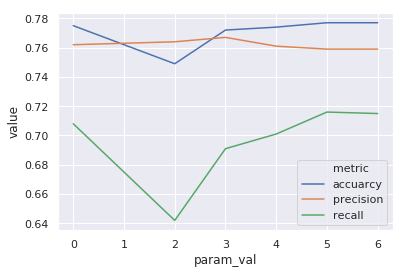

In [126]:
sns.set()
sns.lineplot(x=results_formatted.param_val, y=results_formatted.value, hue=results_formatted.metric)

### min_samples_split

In [127]:
param='min_samples_split'
for i, param_val in enumerate([2,3,4,5,6,7]):
    if i ==0:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(min_samples_split=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results_all = _eval.get_results()
        results_all['param_val'] = param_val
    else:
        # model
        model = Pipeline([('model', GradientBoostingClassifier(min_samples_split=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results = _eval.get_results()
        results['param_val'] = param_val    
        results_all = results_all.append(results, sort=False)

In [128]:
results_all = results_all[results_all.result=='cross validation']
results_all.reset_index(inplace=True, drop=True)
results_all.param_val.fillna(0, inplace=True)

results_formatted = {'experiment':[],'param':[],'param_val':[],'metric':[],'value':[]}
for i in list(results_all.index):
    results = results_all.iloc[i]
    for metric in ['accuarcy', 'precision', 'recall']:
        results_formatted['experiment'].append(results.experiment)
        results_formatted['param'].append(param)
        results_formatted['param_val'].append(results.param_val)
        results_formatted['metric'].append(metric)
        results_formatted['value'].append(results[metric])
results_formatted = pd.DataFrame(results_formatted)
results_formatted_all=results_formatted_all.append(results_formatted)

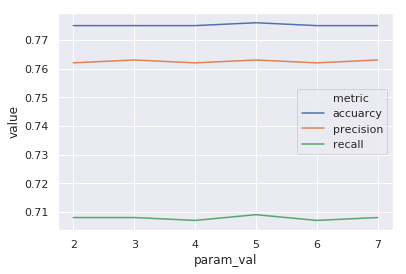

In [129]:
sns.set()
sns.lineplot(x=results_formatted.param_val, y=results_formatted.value, hue=results_formatted.metric)

##Â Summary for Report

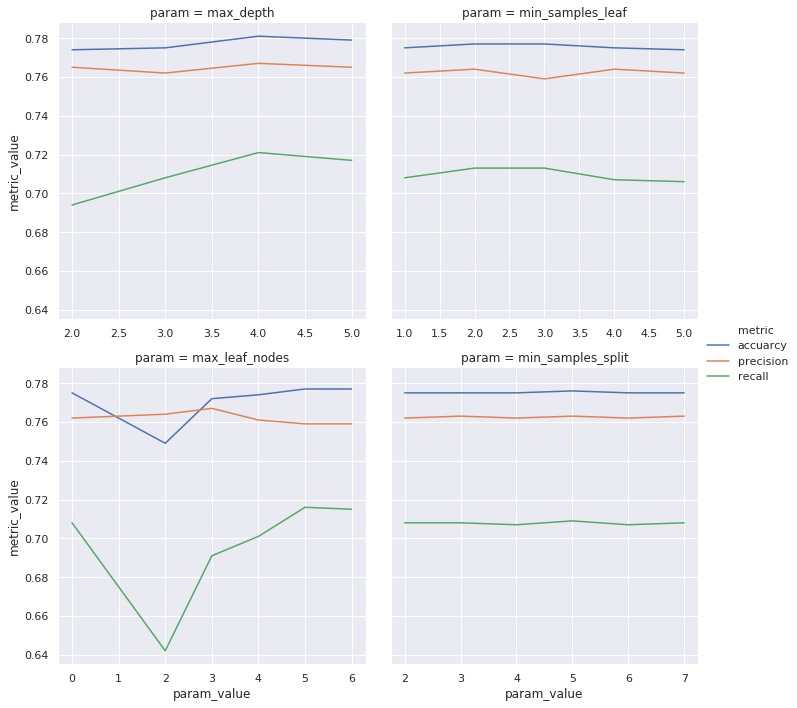

In [149]:
# create facetgrid
g = sns.FacetGrid(results_formatted_all, col='param', col_wrap=2, sharex=False, legend_out=True, height=5);
g.map(sns.lineplot, 'param_val', 'value', 'metric');

g.add_legend();

#g.fig.suptitle('Figure X. Effect of hyperparameter values on precision, recall and accuracy metrics for Gradient Boosting Classifer.',
#               x=0, y=-0.02, verticalalignment = 'bottom', horizontalalignment='left');

g.set_axis_labels('param_value', 'metric_value');
